# Libraries

In [27]:
%load_ext autoreload
%autoreload 2
import random
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from benchmarks.models.kriging import kriging_external_drift
import tqdm as tqdm
import time
import geopandas as gpd

from utils.load import *
from utils.visualisation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
config = read_config('config.yaml')

# Load Dataset

In [9]:
radar_df = load_radar_dataset(folder_name='sg_radar_data')
raingauge_df = load_raingauge_dataset('rainfall_data.csv', N=0)
cml_df = load_cml_dataset('CML_data_processed_2025.nc')
print(radar_df.shape)
print(raingauge_df.shape)
print(cml_df.shape)

The size of dataset is 8334
(8334, 5)
(26096, 63)
(6991632, 27)


In [10]:
raingauge_rate_df_15mins = raingauge_df.resample('15min').sum().mul(4) #resamples to 15 mins and converts to mm/hour rainfall rate
raingauge_rate_df_5mins = raingauge_df.mul(12) #converts rainrate to instantaneous rainrate(at 5 mins interval)

# Filter for only stations whos coordinates we know

S06: 12256
S07: 4576
S08: 3
S102: 23986
S104: 4573
S106: 2429
S107: 3
S109: 3691
S111: 1694
S112: 3
S113: 4
S115: 14
S116: 3791
S117: 1799
S119: 3
S121: 7018
S123: 3
S201: 8
S203: 3
S207: 9934
S208: 6
S209: 4
S210: 6
S211: 43
S213: 3
S214: 3
S215: 3
S216: 5
S217: 11
S218: 9899
S219: 3
S220: 3
S221: 4
S222: 3
S223: 3
S224: 3
S226: 10
S227: 3
S228: 3
S229: 4
S230: 3
S24: 2359
S29: 3
S33: 106
S40: 7
S43: 4
S44: 1812
S50: 4299
S60: 2609
S64: 5207
S66: 3
S69: 3
S71: 3
S77: 3
S78: 1623
S79: 911
S81: 1854
S84: 3
S88: 40
S90: 3
S900: 365
S92: 3
S94: 10
gid                  S06  S07  S08  S102  S104  S106  S107  S109  S111  S112  \
time_sgt                                                                       
2025-01-30 00:05:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:10:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:15:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:20:00  0.0  0.0  0.0   NaN   0.0   

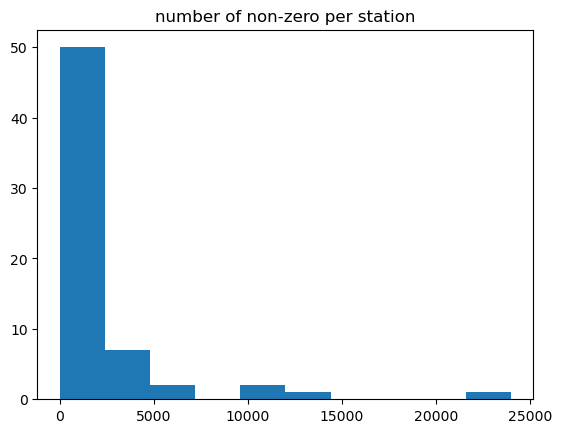

In [11]:
raingauge_sampling_method = "5mins"

station_dict = get_gauge_coordinate_mappings()
filter_cols = [s for s in raingauge_df.columns]

if raingauge_sampling_method == "5mins":
  station_aligned_raingauge_df = raingauge_rate_df_5mins[filter_cols]
elif raingauge_sampling_method == "15mins":
  station_aligned_raingauge_df = raingauge_rate_df_15mins[filter_cols]

raingauge_station_count = len(filter_cols)

#Count the number of na values per col
nan_values = []
for col in filter_cols:
  column_data = station_aligned_raingauge_df[col].values
  nans = np.sum(np.isnan(column_data))
  print(f"{col}: {nans}")
  nan_values.append(nans)

print(raingauge_rate_df_5mins)
raingauge_rate_df_5mins.to_csv("processed_rain.csv")
plt.figure()
plt.title("number of non-zero per station")
plt.hist(nan_values, bins=10)
plt.show()

# MERGE RADAR DATA AND RAIN GAUGE DATA

min: 0.0, max: 180.0, average: 0.40050061843514306


Text(0, 0.5, 'Count (Log scale)')

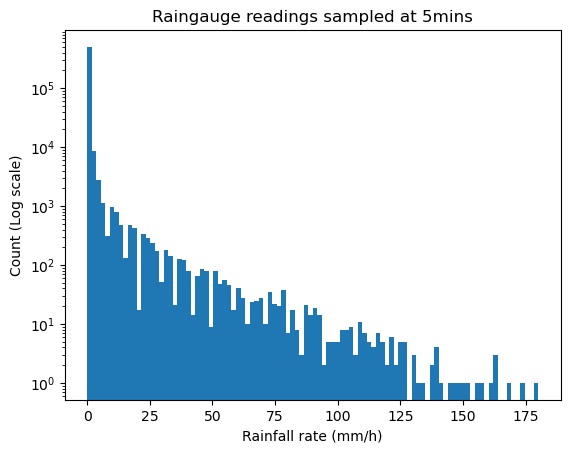

In [12]:
merged_df = pd.merge(station_aligned_raingauge_df, radar_df, on='time_sgt', how='inner').fillna(0) # Hacky solutions for now. Need to figure out what to do with na values

avg = merged_df.values[:, 1:-4].mean()
min = merged_df.values[:, 1:-4].min()
max = merged_df.values[:, 1:-4].max()

print(f"min: {min}, max: {max}, average: {avg}")
flattened_arr = merged_df.values[:, 1:-4].flatten()

plt.hist(flattened_arr, bins=100, log=True)
plt.title(f"Raingauge readings sampled at {raingauge_sampling_method}")
plt.xlabel("Rainfall rate (mm/h)")
plt.ylabel("Count (Log scale)")

# Calculate Kriging Loss

In [13]:
random.seed(111)
total_RMSE_loss = 0.0
invalid_kriges = 0
count = 0
training_ratio = config['dataset_parameters']['train_size']
station_names = list(merged_df.columns[:-4])
station_names.remove('time_sgt')
training_stations = random.sample(station_names, int(len(station_names) * training_ratio))
validation_stations = [s for s in station_names if s not in training_stations]
loss_arr = []

start = time.time()
total_RMSE_loss = 0.0

for i in tqdm.tqdm(range(len(merged_df))):
  count += 1
  df = merged_df.iloc[i]
  station_names=list(df.index[:-4]) #HARDCODED
  station_names.remove('time_sgt')

  kriging_result, keiging_variance = kriging_external_drift(df=df, 
                                                            station_names=training_stations, 
                                                            station_dict=station_dict, 
                                                            variogram_model='exponential', 
                                                            method='KED')
  # print(kriging_result) #kriging_result[row][col]
  # plt.imshow(kriging_result, origin='lower')
  if kriging_result is None:
    invalid_kriges += 1
    continue

  #Calculate RMSE for each timestamp
  instance_errors = []
  for validation_station in validation_stations:
    rain_gauge_value = df[validation_station]
    lat, long = station_dict[validation_station]
    row = math.floor((lat - 1.14) / 0.01)
    col = math.floor((long - 103.6) / 0.01)
    kriged_value = kriging_result[row][col]

    instance_errors.append(((kriged_value - rain_gauge_value) ** 2))

  instance_RMSE = np.sqrt(np.mean(np.array(instance_errors)))
  loss_arr.append(instance_RMSE)
  # print(f"RMSE: {RMSE}")
end = time.time()
print(f"invalid_kriges {invalid_kriges}")
print(len(merged_df))
print(np.mean(np.array(loss_arr)))

print(f"final average loss: {np.mean(np.array(loss_arr))}")
print(f"average_kriging_loss(0 data = 0 loss): {np.sum(np.array(loss_arr))/len(merged_df)}")
print(f'time taken: {end - start}')


100%|██████████| 8242/8242 [02:28<00:00, 55.49it/s] 

invalid_kriges 6680
8242
4.123755313598012
final average loss: 4.123755313598012
average_kriging_loss(0 data = 0 loss): 0.7815221790633456
time taken: 148.54903602600098


# Plot raingauge and radar data on the same grid

# General plotting function (Hard coded for max 9 plots for now)

[autoreload of utils.visualisation failed: Traceback (most recent call last):
  File "/opt/miniconda3/envs/fyp/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/fyp/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
  File "/opt/miniconda3/envs/fyp/lib/python3.13/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 1022, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1160, in get_code
  File "<frozen importlib._bootstrap_external>", line 1090, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/jylow/Documents/FYP/rainfa

                     geometry  values
0     POINT (103.9007 1.3524)     2.4
1     POINT (103.8334 1.3415)     0.0
2     POINT (103.8271 1.3701)     2.4
3       POINT (103.768 1.189)     0.0
4   POINT (103.78538 1.44387)     0.0
..                        ...     ...
58    POINT (103.8482 1.3427)     0.0
59    POINT (103.8191 1.3191)     0.0
60  POINT (103.86922 1.41284)     4.8
61    POINT (103.7886 1.2841)     0.0
62    POINT (103.9528 1.3662)     4.8

[63 rows x 2 columns]
BoundingBox(left=102.45, bottom=-0.6200000000000001, right=105.72, top=2.65)
(31, 45)
                     geometry  values
0     POINT (103.9007 1.3524)     2.4
1     POINT (103.8334 1.3415)     2.4
2     POINT (103.8271 1.3701)     2.4
3       POINT (103.768 1.189)     0.0
4   POINT (103.78538 1.44387)     0.0
..                        ...     ...
58    POINT (103.8482 1.3427)     0.0
59    POINT (103.8191 1.3191)     0.0
60  POINT (103.86922 1.41284)     4.8
61    POINT (103.7886 1.2841)     0.0
62    POINT (103.

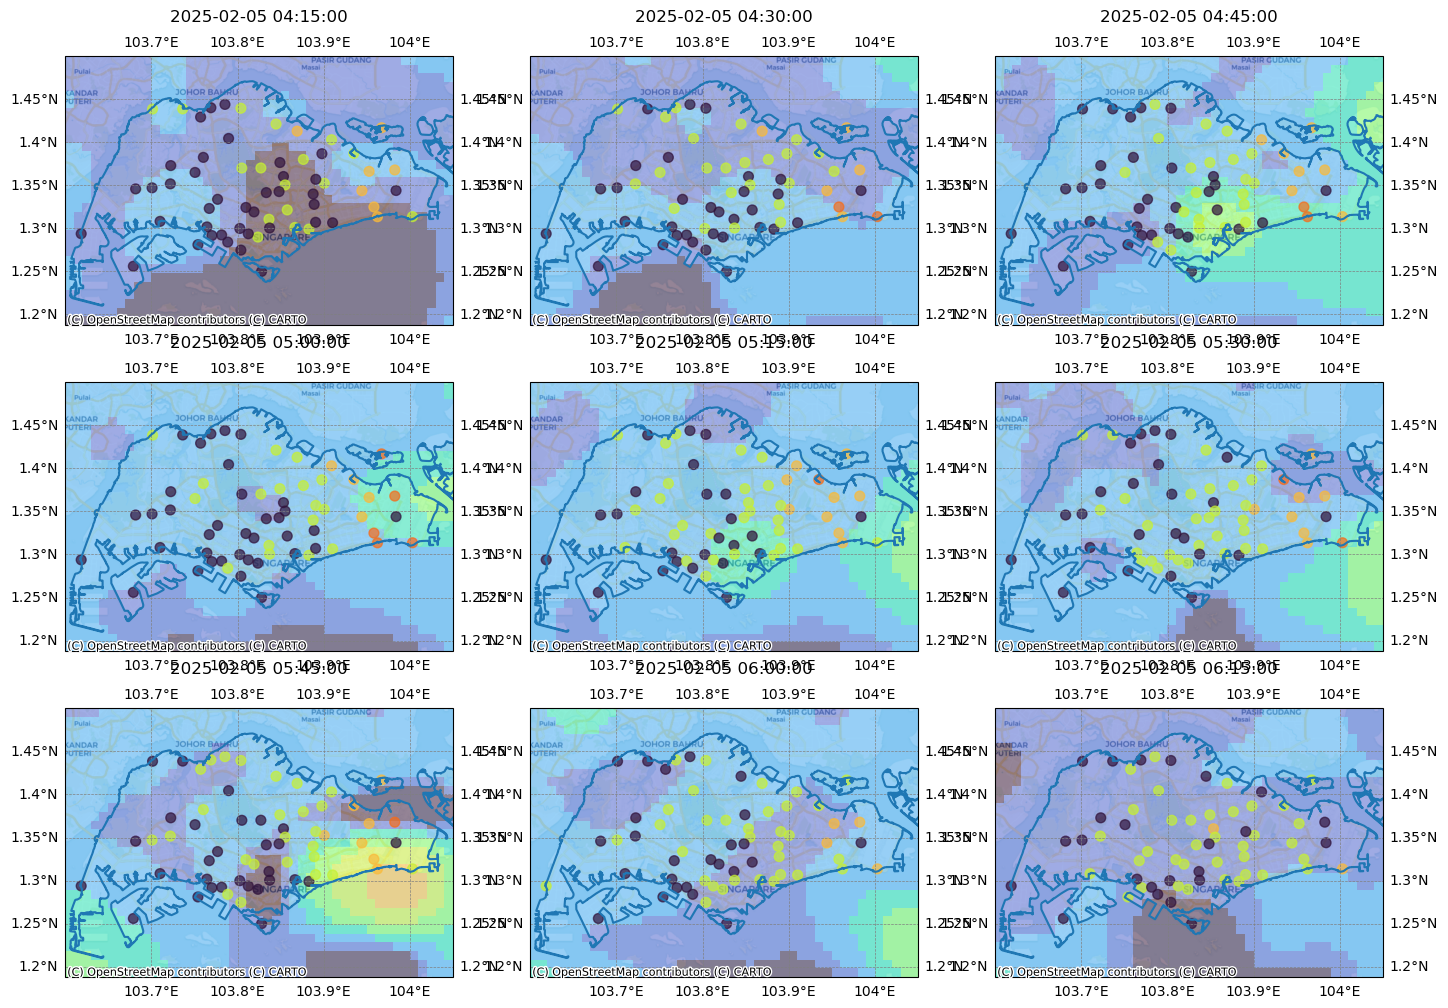

In [14]:
import cartopy
import cartopy.io.shapereader as shpreader

R = 3
C = 3

fig, ax = plt.subplots(R, C, figsize=(17,12), sharex=True, sharey=True, subplot_kw={'projection' : ccrs.PlateCarree()})

bounds_singapore = {
  'left': 103.6,
  'right': 104.05,
  'top': 1.5,
  'bottom': 1.188
}

# #iterrate through rows
# for index, row in merged_df.head(R * C).iterrows():
#   node_df = pandas_to_geodataframe(row)
#   radar_input = row[['data', 'bounds', 'crs', 'transform']]
#   visualise_gauge_grid(node_df=node_df, ax=ax[int(index / 2)][index % 2])
#   visualise_radar_grid(data=radar_input, ax=ax[int(index / 2)][index % 2], zoom=None, scaling=None, alpha=0.5, legend=False)
#   cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Voyager)

plt.plot()
count = 0
#single plot
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
for index, row in merged_df[332:].head(9).iterrows():
  a = count // 3
  b =count % 3
  timestamp = row['time_sgt']
  node_df = pandas_to_geodataframe(row)
  print(node_df)
  radar_input = row[['data', 'bounds', 'crs', 'transform']]
  ax[a][b].set_title(timestamp)
  visualise_gauge_grid(node_df=node_df, ax=ax[a][b])
  im, axi = improved_visualise_radar_grid(data=radar_input, ax=ax[a][b], zoom=bounds_singapore, title=timestamp, norm=norm) 
  #visualise_radar_grid(data=radar_input, ax=ax[a][b], zoom=bounds_singapore, scaling=None, alpha=0.5, legend=False)
  cx.add_basemap(axi, crs=4326, source=cx.providers.CartoDB.Voyager, alpha=0.5)


  # Get country borders
  visualise_singapore_outline(axi)
  
  count += 1


  

# TEMP: Load CML 

In [15]:
cml_df.rename(columns={'time': 'time_sgt'}, inplace=True)
cml_df['lat'] = (cml_df['site_a_latitude'] + cml_df['site_b_latitude'])/2
cml_df['lon'] = (cml_df['site_a_longitude'] + cml_df['site_b_longitude'])/2

# #vals = ['trsl', 'wet', 'baseline', 'waa', 'A', 'R','frequency', 'length', 'lat', 'lon']
# vals = ['R', 'frequency', 'lat','lon']

In [16]:
vals = list(cml_df.columns.drop(['time_sgt', 'link_id', 'station']))
df_pivoted = cml_df.pivot(index='time_sgt', columns=['link_id', 'station'], values='R')
print(df_pivoted)

link_id             AMK_1012_1655_59-ODU_25-ODU            \
station                               Station A Station B   
time_sgt                                                    
2025-02-01 00:00:00                         0.0       0.0   
2025-02-01 00:15:00                         0.0       0.0   
2025-02-01 00:30:00                         0.0       0.0   
2025-02-01 00:45:00                         0.0       0.0   
2025-02-01 01:00:00                         0.0       0.0   
...                                         ...       ...   
2025-04-29 23:00:00                         0.0       0.0   
2025-04-29 23:15:00                         0.0       0.0   
2025-04-29 23:30:00                         0.0       0.0   
2025-04-29 23:45:00                         0.0       0.0   
2025-04-30 00:00:00                         0.0       0.0   

link_id             AMK_1064_AMK271B_23-ODU_23-ODU            \
station                                  Station A Station B   
time_sgt         

In [17]:
#df_result contains the average rainfall rate between station A, B for each location

df_result = df_pivoted.groupby(level=0, axis=1).agg('mean')
df_result = df_result.reset_index()
print(df_result)

link_id            time_sgt  AMK_1012_1655_59-ODU_25-ODU  \
0       2025-02-01 00:00:00                          0.0   
1       2025-02-01 00:15:00                          0.0   
2       2025-02-01 00:30:00                          0.0   
3       2025-02-01 00:45:00                          0.0   
4       2025-02-01 01:00:00                          0.0   
...                     ...                          ...   
8439    2025-04-29 23:00:00                          0.0   
8440    2025-04-29 23:15:00                          0.0   
8441    2025-04-29 23:30:00                          0.0   
8442    2025-04-29 23:45:00                          0.0   
8443    2025-04-30 00:00:00                          0.0   

link_id  AMK_1064_AMK271B_23-ODU_23-ODU  AMK_1064_AMK271B_24-ODU_24-ODU  \
0                                   0.0                             0.0   
1                                   0.0                             0.0   
2                                   0.0               

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_3179/2022662763.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_result = df_pivoted.groupby(level=0, axis=1).agg('mean')


In [18]:
# df_pivoted = cml_df.pivot(index='time_sgt', columns=['link_id', 'station'], values=vals)

# def process_row(row):
#     x = row.tolist()
#     new_row = []
#     print(x)
#     new_row.append(x[0]) #freq
#     new_row.append(x[2]) #lat
#     new_row.append(x[4]) #lon
#     new_row.append((x[6] + x[7]) / 2)
#     return new_row

# def combine_stations_and_values_v1(df_pivoted):
#     """
#     Combine stations and aggregate values into arrays using groupby
#     (I don't really know how this works. But the output is [R, R, frequency, frequency, lat, lat, lon, lon, trslA, trslB])
#     """
#     # Stack to convert columns to rows, keeping time_sgt as index
#     stacked = df_pivoted.stack(level=[0, 1, 2])  # Stack all column levels
#     stacked = stacked.reset_index()
    
#     # Rename columns for clarity
#     stacked.columns = ['time_sgt', 'value_type', 'link_id', 'station', 'value']
    
#     # Group by time_sgt and link_id, then aggregate all values into lists
#     result = stacked.groupby(['time_sgt', 'link_id'])['value'].apply(
#         process_row  # Remove NaN values and convert to list
#     ).unstack(level='link_id')
    
#     return result

# df_result = combine_stations_and_values_v1(df_pivoted)


In [19]:
# df_result = df_result.reset_index()
# print(df_result.reset_index().columns)

In [20]:
copied_df = merged_df.copy()

In [21]:
all_sources_df = pd.merge(copied_df, df_result, on='time_sgt', how='inner')
print(all_sources_df)

                time_sgt  S06  S07  S08  S102  S104  S106  S107  S109  S111  \
0    2025-02-01 00:15:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1    2025-02-01 00:30:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2    2025-02-01 00:45:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3    2025-02-01 01:00:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4    2025-02-01 01:15:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...   
8137 2025-04-29 22:45:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8138 2025-04-29 23:00:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8139 2025-04-29 23:15:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8140 2025-04-29 23:30:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8141 2025-04-29 23:45:00  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

      ...  YIS_21290_38150_25-ODU_25-ODU  YIS_50190

In [22]:
# df_pivoted = cml_df.pivot_table(index='time', columns=['link_id', 'station'], values='R')
# df_pivoted.columns = [f'{link_id}_{station}' for link_id, station in df_pivoted.columns]
# df_pivoted = df_pivoted.reset_index()
# df_pivoted.rename(columns={'time': 'time_sgt'}, inplace=True)

# copied_df = merged_df.copy()
# copied_df = pd.merge(copied_df, df_pivoted, on='time_sgt', how='inner')
# print(copied_df.iloc[0])


# pd_df.rename(columns={'time_sg': 'time_sgt'}, inplace=True)
# print(pd_df)
# print(merged_df)
# merged_df = pd.merge(pd_df, merged_df, on='time_sgt', how='inner')
# print(merged_df)

In [23]:
#get coordinate points for each station in CML
# print(cml_df)

cml_coordinate_info = cml_df[['link_id', 'lat', 'lon']]
cml_coordinate_info = cml_coordinate_info.groupby('link_id').agg('mean')

print(cml_coordinate_info.loc('AMK_1012_1655_59-ODU_25-ODU'))

ValueError: No axis named AMK_1012_1655_59-ODU_25-ODU for object type DataFrame

In [ ]:
def interpolate_scattered_to_grid(scattered_x, scattered_y, scattered_values, 
                                  grid_x, grid_y, method='linear'):
    """
    Interpolate scattered point data to a regular grid
    """
    from scipy.interpolate import griddata
    
    # Create grid points
    X_grid, Y_grid = np.meshgrid(grid_x, grid_y)
    grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    
    # Interpolate scattered data to grid
    scattered_points = np.column_stack([scattered_x, scattered_y])

    interpolated_values = griddata(
        scattered_points, 
        scattered_values, 
        grid_points, 
        method=method,
        fill_value=np.nan
    )
    
    # Reshape back to grid
    return interpolated_values.reshape(X_grid.shape)

In [ ]:
from pykrige.uk import UniversalKriging

variogram_model = "gaussian"

fig, axes = plt.subplots(nrows=2, ncols=2)
row_data = all_sources_df.iloc[3].dropna()

raingauge_station_names = list(row_data.index[:raingauge_station_count])
cml_station_names = list(row_data.index[raingauge_station_count + 5:])

data = [] #initialise array

for s in raingauge_station_names[2:]:
  lat, long = station_dict[s]
  data.append([long, lat, row_data[s]])

gauge_data = np.array(data)
 
data = [] #initialise array

for s in cml_station_names:
   lat, lon = cml_coordinate_info.loc[s]
   data.append([lon, lat, row_data[s]])

cml_data = np.array(data)

gridx = np.arange(103.605, 104.05, 0.01)
gridy = np.arange(1.145, 1.51, 0.01)

#RADAR FOR USE IN EXTERNAL DRIFT

radar_grid = row_data['data']
bounds = row_data['bounds']
transform = row_data['transform']
x_min = bounds.left
y_max = bounds.top
pixel_width = transform[0]
pixel_height = -transform[4]

axes[0][0].imshow(radar_grid, origin='lower')

e_d = []
e_dx = []
e_dy = []

for row in range(radar_grid.shape[0]): 
    y = y_max - (row * pixel_height) + pixel_height / 2
    e_dy.append(y)

for col in range(radar_grid.shape[0]):

    # Calculate middle of cell
    x = x_min + (col * pixel_width) + pixel_width / 2
    e_dx.append(x)


e_dx = np.array(e_dx)
e_dy = np.array(e_dy)


#Need to interpolate the cml values to the grid in order ot use function

second_var_grid = interpolate_scattered_to_grid(
   cml_data[:, 0],
   cml_data[:, 1],
   cml_data[:, 2],
   e_dx,
   e_dy
)

numpy_array = np.array(second_var_grid)

# Replace NaN values with 0 using nan_to_num
converted_array = np.nan_to_num(numpy_array, nan=0.0)

# If you need to convert it back to a list of lists
second_var_grid = converted_array

cml_radar_grid = np.column_stack([radar_grid, second_var_grid])


KED_with_radar = UniversalKriging(
    x=gauge_data[:, 0],
    y=gauge_data[:, 1],
    z=gauge_data[:, 2],
    variogram_model=variogram_model,
    drift_terms=["external_Z"],
    external_drift=radar_grid,
    external_drift_x=e_dx,
    external_drift_y=e_dy,
    pseudo_inv=True
)

KED_with_radar_cml = UniversalKriging(
    x=gauge_data[:, 0],
    y=gauge_data[:, 1],
    z=gauge_data[:, 2],
    variogram_model=variogram_model,
    drift_terms=['external_Z'],
    external_drift=second_var_grid,
    external_drift_x=e_dx,
    external_drift_y=e_dy,
    pseudo_inv=True
)

UK = UniversalKriging(
    gauge_data[:, 0],
    gauge_data[:, 1],
    gauge_data[:, 2],
    variogram_model=variogram_model,
    drift_terms=["regional_linear"],
    pseudo_inv=True
)


z,ss = KED_with_radar.execute("grid", gridx, gridy)
z2,ss2 = UK.execute("grid", gridx, gridy)
z3,ss3 = KED_with_radar_cml.execute("grid", gridx, gridy)

axes[0][1].imshow(z2, origin='lower') #Universal kriging
axes[0][1].set_title("universal kriging")
axes[1][0].imshow(z, origin='lower') #UKriging with external drift
axes[1][0].set_title("KED")
axes[1][1].imshow(z3, origin='lower') #Kriging with external drift CML + radar
axes[1][1].set_title("KED + cml")
plt.show()

In [ ]:
AWSdf = load_weather_station_dataset('weather_station_data.csv')
cols = AWSdf.columns.values.tolist()
print(cols)
cols.remove('time_sgt')
cols.remove('gid')
print(cols)

AWSdf = AWSdf.pivot(index='time_sgt', columns='gid', values=cols)
#print(AWSdf.columns)

for idx in AWSdf.columns:
  val = AWSdf[idx].notna().sum()
  print(val)


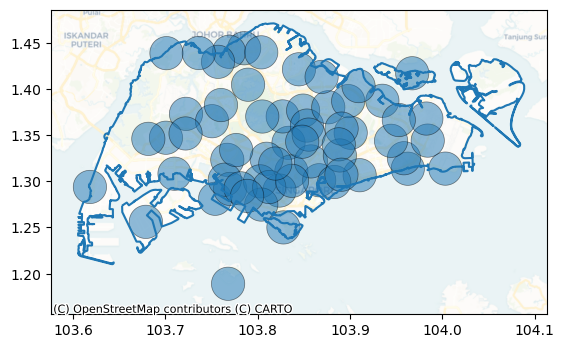

In [33]:
fig,ax = plt.subplots()
visualise_gauge_radius(node_df=node_df, ax=ax)
visualise_singapore_outline(ax=ax)
visualise_with_basemap(ax=ax)